In [1]:
import harmonica as hm
import numpy as np
import verde as vd
import xarray as xr
import magali as mg
import matplotlib.pyplot as plt

In [6]:
sensor_sample_distance = 5.0  # µm
region=[0, 2000, 0, 2000] # µm
spacing=2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[11.73998063, 11.92960594, 12.12355003, ..., 18.32321142,
        18.23110923, 18.12156131],
       [11.84953477, 12.04243922, 12.23978239, ..., 18.8590746 ,
        18.7645734 , 18.65064765],
       [11.95937084, 12.15558609, 12.35636243, ..., 19.4282814 ,
        19.33085247, 19.21180119],
       ...,
       [ 3.04687567,  3.06668459,  3.08670202, ...,  3.86723782,
         3.83841647,  3.80980578],
       [ 3.02876715,  3.04841467,  3.0682685 , ...,  3.82818792,
         3.79992216,  3.77186141],
       [ 3.0107882 ,  3.03027505,  3.04996599, ...,  3.78975812,
         3.76203299,  3.73450743]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

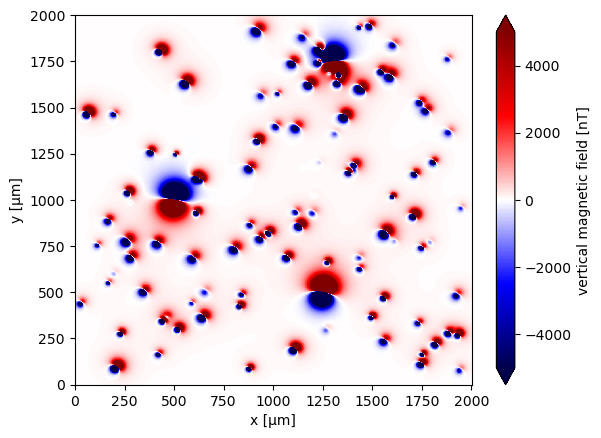

In [7]:
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [8]:
def horizontal_derivatives(data):
    """
    Compute first-order spatial derivatives in the x and y directions.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    """
    dx = hm.derivative_easting(data)
    dy = hm.derivative_northing(data)
    return dx, dy

In [9]:
dx, dy = horizontal_derivatives(data)

In [10]:
spacing = np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])

In [12]:
data_up = hm.upward_continuation(data, spacing).assign_coords(x=data.x, y=data.y)
data_down = hm.upward_continuation(data, -spacing).assign_coords(x=data.x, y=data.y)
dz = (data_up - data_down) / (2 * spacing)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [13]:
tga = np.sqrt(dx**2 + dy**2 + dz**2)

In [15]:
tga.attrs = {"long_name": "total gradient amplitude", "units": "nT/µm"}
dx.attrs = {"long_name": "x-derivative", "units": "nT/µm"}
dy.attrs = {"long_name": "y-derivative", "units": "nT/µm"}
dz.attrs = {"long_name": "z-derivative", "units": "nT/µm"}

In [16]:
data = xr.Dataset({"tga": tga, "x_deriv": dx, "y_deriv": dy, "z_deriv": dz})

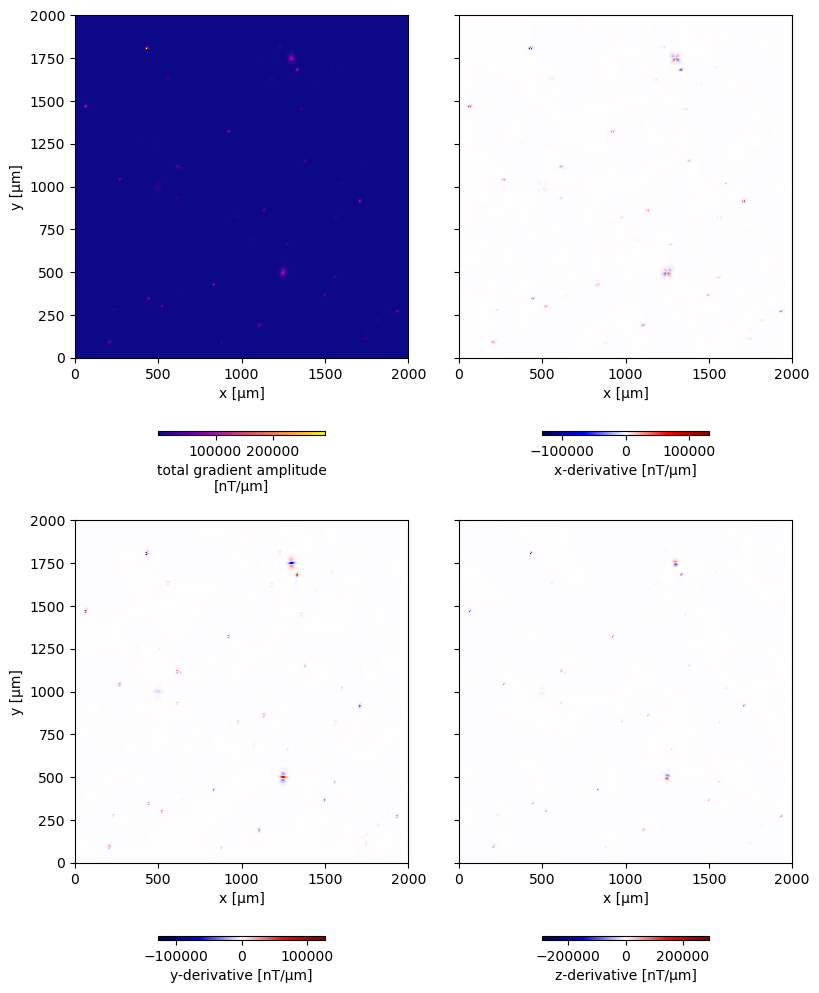

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    
    data[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
        
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)